In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(r"C:\Users\hp\Desktop\jupyter\nagamese_dataset.csv")

In [3]:
data

,Tom's packing.,tom packing kuri ase
0,Tom's unarmed.,tom la haat dey eiku nai
1,Tom's violent.,tom bishi khussa oethe
2,Tom's working.,tom bishi kaam kure
3,Tom's wounded.,tom jokhom baina ase
4,Try to resist.,resist kurivole try kurivi
...,...,...
994,I'm very upset.,moi ekdam mon biya baina ase
995,I'm wide awake.,moi oethina ase
996,I've been busy.,moi kaam thakise
997,I've done that.,moi eitu kurise


In [4]:
data.head

<bound method NDFrame.head of       Tom's packing.          tom packing kuri ase
0     Tom's unarmed.      tom la haat dey eiku nai
1     Tom's violent.        tom bishi khussa oethe
2     Tom's working.           tom bishi kaam kure
3     Tom's wounded.          tom jokhom baina ase
4     Try to resist.    resist kurivole try kurivi
..               ...                           ...
994  I'm very upset.  moi ekdam mon biya baina ase
995  I'm wide awake.               moi oethina ase
996  I've been busy.              moi kaam thakise
997  I've done that.               moi eitu kurise
998  I've forgotten.                  moi bahorise

[999 rows x 2 columns]>

In [5]:
data.columns = ['English', 'Nagamese']

In [6]:
data.head()

,English,Nagamese
0,Tom's unarmed.,tom la haat dey eiku nai
1,Tom's violent.,tom bishi khussa oethe
2,Tom's working.,tom bishi kaam kure
3,Tom's wounded.,tom jokhom baina ase
4,Try to resist.,resist kurivole try kurivi


In [7]:
df = data.copy()

In [8]:
df.head()


,English,Nagamese
0,Tom's unarmed.,tom la haat dey eiku nai
1,Tom's violent.,tom bishi khussa oethe
2,Tom's working.,tom bishi kaam kure
3,Tom's wounded.,tom jokhom baina ase
4,Try to resist.,resist kurivole try kurivi


In [9]:
df.columns = ['English', 'Nagamese']

In [10]:
df.head()

,English,Nagamese
0,Tom's unarmed.,tom la haat dey eiku nai
1,Tom's violent.,tom bishi khussa oethe
2,Tom's working.,tom bishi kaam kure
3,Tom's wounded.,tom jokhom baina ase
4,Try to resist.,resist kurivole try kurivi


In [11]:
df = df.dropna()


In [12]:
train, test = train_test_split(df, test_size=0.1, random_state=42)

# Save the datasets to files
train.to_csv("train.csv", index=False)
test.to_csv("val.csv", index=False)

In [13]:
train['English']
type(train['English'])

pandas.core.series.Series

In [14]:
train['Nagamese']
type(train['Nagamese'])

pandas.core.series.Series

In [15]:
# Convert the series to lists
train_english_sentences = train['English'].tolist()
train_nagamese_sentences = train['Nagamese'].tolist()
val_english_sentences = test['English'].tolist()
val_nagamese_sentences = test['Nagamese'].tolist()

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# Tokenize the text data
def tokenize_text(texts, num_words=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<unk>')
    tokenizer.fit_on_texts(texts)
    return tokenizer

In [18]:
# Convert text sequences into numerical sequences
def sequences(tokenizer, texts, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen, padding='post')


In [19]:
# English Tokenization
english_tokenizer = tokenize_text(train_english_sentences)
eng_vocab_size = len(english_tokenizer.word_index) + 1
eng_maxlen = max(len(line.split()) for line in train_english_sentences)

In [20]:
# Nagamese Tokenization
nagamese_tokenizer = tokenize_text(train_nagamese_sentences)
nag_vocab_size = len(nagamese_tokenizer.word_index) + 1
nag_maxlen = max(len(str(line).split()) for line in train_nagamese_sentences)

In [21]:
# Prepare training data
X_train = sequences(nagamese_tokenizer, train_nagamese_sentences, nag_maxlen)
y_train = sequences(english_tokenizer, train_english_sentences, eng_maxlen)

# Prepare validation data
X_val = sequences(nagamese_tokenizer, val_nagamese_sentences, nag_maxlen)
y_val = sequences(english_tokenizer, val_english_sentences, eng_maxlen)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, RepeatVector


In [23]:
def build_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(n_units)))
    model.add(Dropout(0.2))
    model.add(RepeatVector(tar_timesteps))
    model.add(Bidirectional(LSTM(n_units, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(tar_vocab, activation='softmax'))
    return model

In [24]:
n_units = 256

# Build the model
model = build_model(nag_vocab_size, eng_vocab_size, nag_maxlen, eng_maxlen, n_units)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 256)            199424    
                                                                 
 bidirectional (Bidirection  (None, 512)               1050624   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 5, 512)            0         
 r)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 512)            1574912   
 onal)                                                           
                                                      

In [33]:
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
                    epochs=20, batch_size=128, 
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], y_val.shape[1], 1)))

Epoch 1/20
7/7 [==============================] - 2s 326ms/step - loss: 3.4659 - accuracy: 0.4298 - val_loss: 3.8505 - val_accuracy: 0.4364
Epoch 2/20
7/7 [==============================] - 2s 305ms/step - loss: 3.4125 - accuracy: 0.4298 - val_loss: 3.8794 - val_accuracy: 0.4364
Epoch 3/20
7/7 [==============================] - 2s 316ms/step - loss: 3.3658 - accuracy: 0.4303 - val_loss: 3.8538 - val_accuracy: 0.4384
Epoch 4/20
7/7 [==============================] - 2s 319ms/step - loss: 3.3379 - accuracy: 0.4325 - val_loss: 3.8559 - val_accuracy: 0.4364
Epoch 5/20
7/7 [==============================] - 2s 319ms/step - loss: 3.3125 - accuracy: 0.4325 - val_loss: 3.8540 - val_accuracy: 0.4384
Epoch 6/20
7/7 [==============================] - 2s 323ms/step - loss: 3.2748 - accuracy: 0.4339 - val_loss: 3.8338 - val_accuracy: 0.4404
Epoch 7/20
7/7 [==============================] - 2s 324ms/step - loss: 3.2413 - accuracy: 0.4375 - val_loss: 3.8260 - val_accuracy: 0.4404
Epoch 8/20
7/7 [====

In [26]:
import matplotlib.pyplot as plt

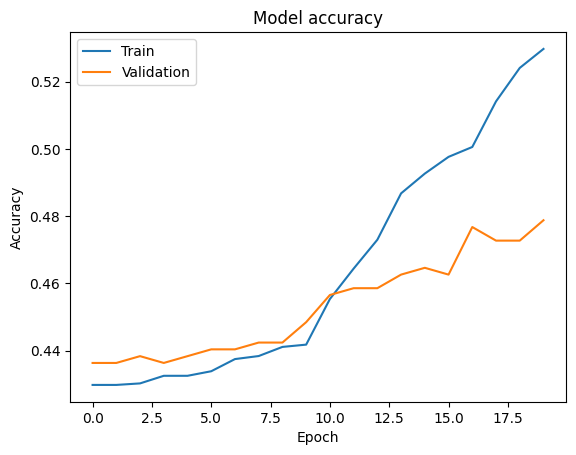

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


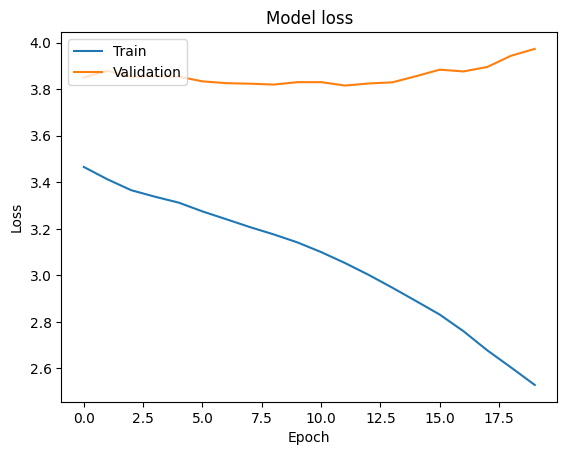

In [35]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
import numpy as np

In [29]:
def translate_sentence(model, tokenizer, sentence, max_length):
    # Tokenize the sentence
    sentence = sentence.lower()
    sentence = [tokenizer.word_index[word] if word in tokenizer.word_index else tokenizer.word_index['<unk>'] for word in sentence.split(' ')]
    # Pad the sequence
    sentence = pad_sequences([sentence], maxlen=max_length, padding='post')
    # Get the prediction
    prediction = model.predict(sentence, verbose=0)
    # Get the index with the highest probability
    prediction = np.argmax(prediction, axis=-1)
    # Decode the prediction
    predicted_sentence = ''
    for index in prediction[0]:
        if index == 0:
            break
        word = tokenizer.index_word[index]
        predicted_sentence += word + ' '
    return predicted_sentence

In [32]:
# Example Translation
sentence = "Tom's unarmed"
translated_sentence = translate_sentence(model, english_tokenizer, sentence, nag_maxlen)
print(translated_sentence)

i i 
